# Building Integrated Stroke Delivery Network (ISDN) footprint geometry

This notebook shows how to build up the geometry of ISDNs from smaller regions of the country. The smaller regions are named either Sustainability and Transformation Partnerships (STPs) or Integrated Care Boards (ICBs) depending on the age of the data. In some cases there are slight mismatches in STPs/ICBs and the reference ISDN maps due to some smaller units being used instead. These are Clinical Commissioning Groups (CCGs) and Sub Integrated Care Board Locations (SICBLs).

We use a reference map of the ISDN areas to work out which STPs or ICBs should be in each ISDN.

This notebook takes each available STP and ICB data set in turn and uses it to recreate the reference maps in the same colours. The code is copy and pasted a lot to allow for different setup for each map, mostly due to the names of STPs and ICBs changing between years.

## Reference maps

There are two reference maps:

![](../images/ISDN_footprints_networks-for-future-healthcare_hargroves.jpg)

Figure 1 
Available online: https://www.rcpjournals.org/content/futurehosp/9/2/118 (accessed 13th February 2024).

Networks for future healthcare  
David Hargroves, Deborah Lowe, Marion Wood, Simon Ray  
Future Healthc J Jul 2022, 9 (2) 118-124; DOI: 10.7861/fhj.2022-0048


And

![](../images/ISDN_footprints_girft-programme-national-specialty-report_hargroves.png)

Figure 4
Available online: https://gmnisdn.org.uk/wp-content/uploads/2022/04/Stroke-GiRFT-report-Apr-22.pdf

Stroke
GIRFT Programme National Specialty Report  
By Dr David Hargroves and Dr Deb Lowe  
GIRFT Clinical Lead for Stroke and Senior Clinical Advisor for Stroke  
April 2022

n.b. the green map's caption says:

    "Adapted with permission from NHS England. Integrated stroke delivery network footprints. NHS, 2020."

Presumably then the green map is adapted from the multicoloured one. The multicoloured map is titled:

    "Figure 4: Integrated Stroke Delivery Network footprints (December 2020)"

Even though the document containing it is not. I assume this multicoloured map was used to create the green map.

## Summary of region file differences

n.b. STPs were renamed to ICBs starting from July 2022.

| File | Diff from previous |
| --- | --- |
| STP 2017 (Feb) | -- |
| STP 2018 (Apr) | Three STPs in Cumbria were merged into one. 'Durham, Darlington, Teesside, Hambleton, Richmondshire and Whitby', 'Northumberland, Tyne and Wear and North Durham', and 'West, North and East Cumbria' became 'Cumbria and North East'. |
| STP 2019 (Apr) | Various STP names change. |
| STP 2020 (Apr) | Big changes to borders of Sussex/Surrey (top middle of Sussex) and Yorkshire/Cumbria. In Yorkshire/Cumbria, the CCG "NHS Hambleton, Richmondshire and Whitby CCG" moves from STP "Cumbria and North East" to "Humber, Coast and Vale". Extra small change to border of Sussex/Surrey in their West. |
| STP 2021 (Apr) | Sussex changes its name. |
| ICB 2022 (Jul) | Big change around Worksop, "NHS Bassetlaw CCG" moves from South Yorkshire to Nottinghamshire. Slight change through Birmingham / Black Country border. |
| ICB 2023 (Apr) | Reinstated extra small change to border of Sussex/Surrey in their west. |

## Results

### Green reference map:

This is a mix of the STP 2019, STP 2020, and ICB 2022 regions.

Parts that match STP 2019 only:
+ Sussex north border, "NHS East Surrey CCG".

Parts that match STP 2020 only:
+ "North East and Cumbria" south border.

Parts that match ICB 2022 only:
+ The large "NHS Bassetlaw CCG" area around Worksop (north Notts / south Yorks).

Parts that do not match either:
+ Border of "North East and Cumbria" ISDN with "West Yorkshire and Harrogate" and "Humber Coast and Vale" ISDN borders.
  + The STP 2020 region named "West Yorkshire and Harrogate" does not actually contain Harrogate, but the STP 2019 region did.
  + The border between "West Yorkshire and Harrogate" ISDN and "Humber Coast and Vale" ISDN is the same at the bottom, then pretends that "West Yorkshire and Harrogate" still contains Harrogate, then continues northwards up to the border with "North East and Cumbria" (as in STP 2020) and meets it near Darlington.
 
I suspect that these mismatching Yorkshire borders were hand-drawn and contain mistakes. The border does not even match any CCG or SICBL boundaries in any year.

### Multicoloured map:

This most closely matches the STP 2019 regions.

Differences:
+ "Colchester CCG", part of south Suffolk, is in East of England (North) according to the STP data but in East of England (South) on the reference map.
+ The border north of Wessex and south of Somerset etc. is wobbly on the STP data but smooth on the reference map.
  + I suspect this map has been hand-drawn and this border contain mistakes.

## Notebook setup

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
# For merging polygons:
from shapely.geometry import Polygon, mapping
from shapely.ops import unary_union

## Colour selection

From green map:

In [2]:
colour_greens_dict = {
    'North East and Cumbria': '#89bd3e',  # Lime green
    'West Yorkshire and Harrogate': '#89bd3e',  # Lime green
    'Humber Coast and Vale': '#89bd3e',  # Lime green
    'South Yorkshire': '#89bd3e',  # Lime green
    'Greater Manchester': '#cdda88',  # Pale green
    'Cheshire and Merseyside': '#cdda88',  # Pale green
    'Lancashire and South Cumbria': '#cdda88',  # Pale green
    'North Midlands': '#0c733c',  # Dark green
    'East Midlands': '#0c733c',  # Dark green
    'West Midlands': '#0c733c',  # Dark green
    'East of England (South)': '#989fa5',  # Mid grey
    'East of England (North)': '#989fa5',  # Mid grey
    'London': '#030303',  # black
    'Kent and Medway': '#454f51',  # Dark grey
    'Sussex': '#454f51',  # Dark grey
    'Frimley ICS': '#454f51',  # Dark grey
    'Wessex': '#454f51',  # Dark grey
    'Thames Valley': '#454f51',  # Dark grey
    'Devon, Cornwall and Isles of Scilly': '#c9cdd0',  # light grey
    'Gloucester, BSW, BNSSG and Somerset': '#c9cdd0',  # light grey
}

In [3]:
colour_greens_series = pd.Series(colour_greens_dict, name='colour')
colour_greens_series.index.name = 'ISDN'

From multicoloured map:

In [4]:
colour_multi_dict = {
    'North East and Cumbria': '#1673be',  # Mid blue
    'West Yorkshire and Harrogate': '#1673be',  # Mid blue
    'Humber Coast and Vale': '#1673be',  # Mid blue
    'South Yorkshire': '#1673be',  # Mid blue
    'Greater Manchester': '#464d4b',  # Grey
    'Cheshire and Merseyside': '#464d4b',  # Grey
    'Lancashire and South Cumbria': '#464d4b',  # Grey
    'North Midlands': '#c52c82',  # Pink
    'East Midlands': '#c52c82',  # Pink
    'West Midlands': '#c52c82',  # Pink
    'East of England (South)': '#0f3b85',  # Dark blue
    'East of England (North)': '#0f3b85',  # Dark blue
    'London': '#29a79b',  # Teal
    'Kent and Medway': '#ff8d27',  # Orange
    'Sussex': '#ff8d27',  # Orange
    'Frimley ICS': '#ff8d27',  # Orange
    'Wessex': '#ff8d27',  # Orange
    'Thames Valley': '#ff8d27',  # Orange
    'Devon, Cornwall and Isles of Scilly': '#30b1db',  # light blue
    'Gloucester, BSW, BNSSG and Somerset': '#30b1db',  # light blue
}

In [5]:
colour_multi_series = pd.Series(colour_multi_dict, name='colour')
colour_multi_series.index.name = 'ISDN'

All colour maps:

In [6]:
colour_series_dict = {
    'greens': colour_greens_series,
    'multi': colour_multi_series
}

## Functions for gathering regions and making a map:

In [7]:
def make_data_for_map(gdf_boundaries, isdn_series, colour_series):

    # Merge in the colours:
    df_isdn_regions = pd.merge(isdn_series, colour_series, left_on='ISDN', right_index=True)
    # Merge colours into the boundaries:
    gdf_boundaries = pd.merge(gdf_boundaries, df_isdn_regions, left_index=True, right_index=True, how='left')
    
    # Glob together smaller regions to make ISDN polygons
    gdf_boundaries_isdn = gdf_boundaries[['ISDN', 'geometry', 'colour']].dissolve(by='ISDN')

    return gdf_boundaries, gdf_boundaries_isdn

In [8]:
def plot_map(gdf_boundaries, gdf_boundaries_isdn, savename=''):
    # Plot:    
    fig, ax = plt.subplots(figsize=(14, 14))
    
    gdf_boundaries.plot(
        ax=ax,
        facecolor=gdf_boundaries['colour'],
        antialiased=False,
        edgecolor='k',
        linewidth=0.5,
        linestyle=':'
    )
    
    gdf_boundaries_isdn.plot(
        ax=ax,
        edgecolor='silver',
        facecolor='none',
        antialiased=False,
        linewidth=1,
    )
    
    ax.set_axis_off()  # Turn off axis line and numbers

    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

## STP 2017



In [9]:
file_input = 'STP_Feb_2017_GCB_in_England_2022_8567178081442829795.geojson'
col_name = 'stp17nm'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['OBJECTID', 'stp17cd', 'stp17nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


In [10]:
print(gdf_boundaries.index)

Index(['West Yorkshire', 'Humber, Coast and Vale', 'Greater Manchester',
       'Cheshire and Merseyside', 'South Yorkshire and Bassetlaw',
       'Staffordshire', 'Shropshire and Telford and Wrekin', 'Derbyshire',
       'Lincolnshire', 'Nottinghamshire',
       'Leicester, Leicestershire and Rutland', 'The Black Country',
       'Birmingham and Solihull', 'Coventry and Warwickshire',
       'Herefordshire and Worcestershire', 'Northamptonshire',
       'Cambridgeshire and Peterborough', 'Norfolk and Waveney',
       'Suffolk and North East Essex', 'Milton Keynes, Bedfordshire and Luton',
       'Hertfordshire and West Essex', 'Mid and South Essex',
       'North West London', 'North Central London', 'North East London',
       'South East London', 'South West London', 'Kent and Medway',
       'Sussex and East Surrey', 'Frimley Health', 'Surrey Heartlands',
       'Cornwall and the Isles of Scilly', 'Devon', 'Somerset',
       'Bristol, North Somerset and South Gloucestershire',
    

In [11]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'West Yorkshire': 'West Yorkshire and Harrogate',
    'Humber, Coast and Vale': 'Humber Coast and Vale',
    'Greater Manchester': 'Greater Manchester',
    'Cheshire and Merseyside': 'Cheshire and Merseyside',
    'South Yorkshire and Bassetlaw': 'South Yorkshire',
    'Staffordshire': 'North Midlands',
    'Shropshire and Telford and Wrekin': 'North Midlands',
    'Derbyshire': 'East Midlands',
    'Lincolnshire': 'East Midlands',
    'Nottinghamshire': 'East Midlands',
    'Leicester, Leicestershire and Rutland': 'East Midlands',
    'The Black Country': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Coventry and Warwickshire': 'West Midlands',
    'Herefordshire and Worcestershire': 'West Midlands',
    'Northamptonshire': 'East Midlands',
    'Cambridgeshire and Peterborough': 'East of England (South)',
    'Norfolk and Waveney': 'East of England (North)',
    'Suffolk and North East Essex': 'East of England (North)',
    'Milton Keynes, Bedfordshire and Luton': 'East of England (South)',
    'Hertfordshire and West Essex': 'East of England (South)',
    'Mid and South Essex': 'East of England (South)',
    'North West London': 'London',
    'North Central London': 'London',
    'North East London': 'London',
    'South East London': 'London',
    'South West London': 'London',
    'Kent and Medway': 'Kent and Medway',
    'Sussex and East Surrey': 'Sussex',
    'Frimley Health': 'Frimley ICS',
    'Surrey Heartlands': 'Frimley ICS',
    'Cornwall and the Isles of Scilly': 'Devon, Cornwall and Isles of Scilly',
    'Devon': 'Devon, Cornwall and Isles of Scilly',
    'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
    'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Bath, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Dorset': 'Wessex',
    'Hampshire and the Isle of Wight': 'Wessex',
    'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
    'Durham, Darlington, Teesside, Hambleton, Richmondshire and Whitby': 'North East and Cumbria',
    'Northumberland, Tyne and Wear and North Durham': 'North East and Cumbria',
    'West, North and East Cumbria': 'North East and Cumbria',
    'Lancashire and South Cumbria': 'Lancashire and South Cumbria' 
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

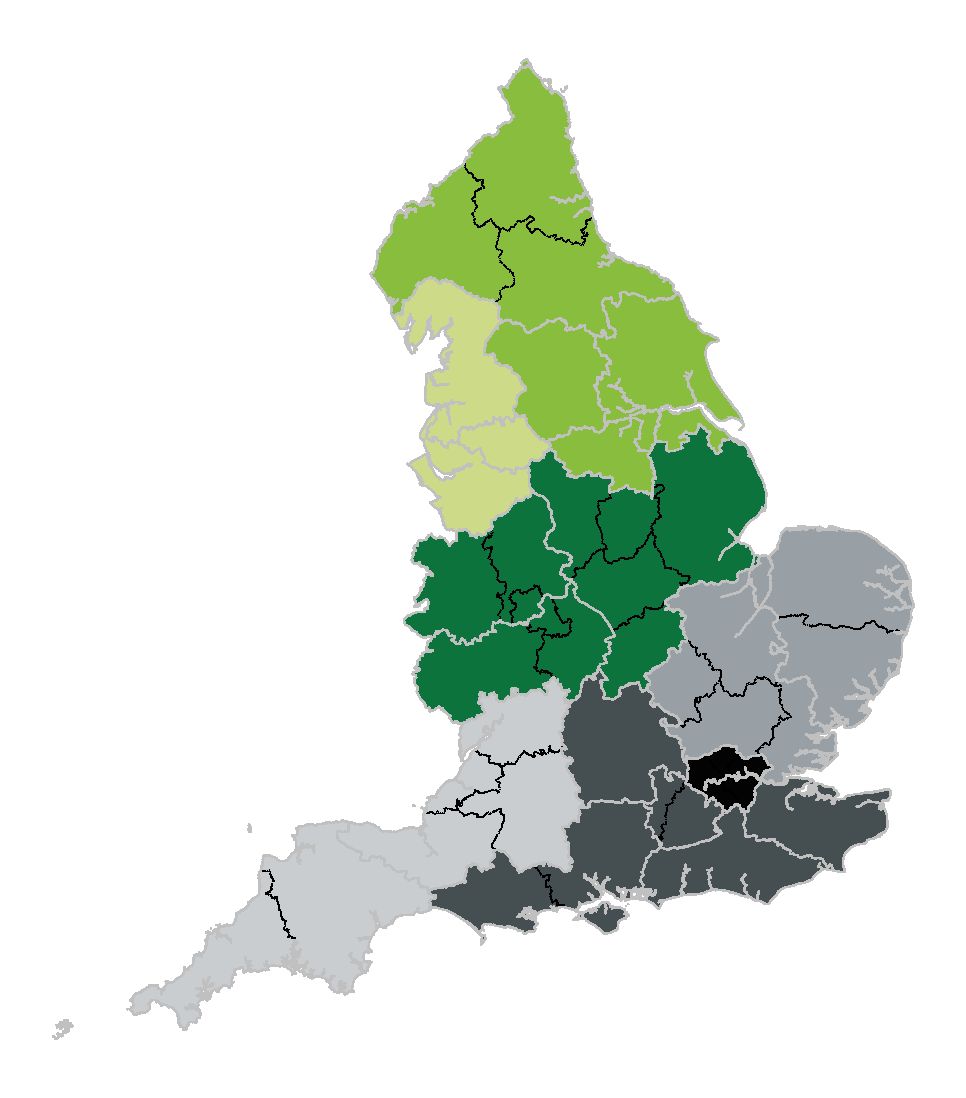

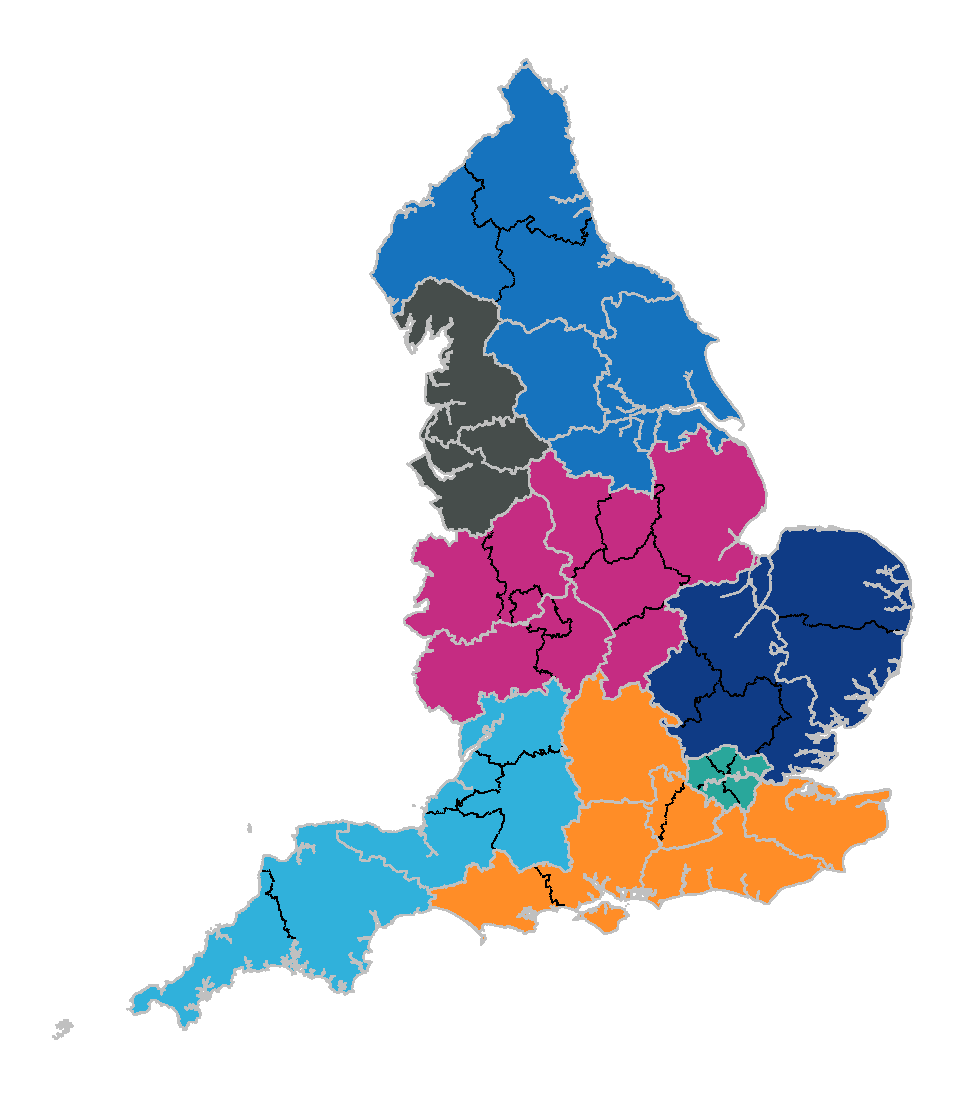

In [12]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## STP 2018

In [43]:
file_input = 'Sustainability_and_Transformation_Partnerships_April_2018_EN_BUC_2022_-2759901949355012834.geojson'
col_name = 'stp18nm'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['OBJECTID', 'stp18cd', 'stp18nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


In [44]:
print(gdf_boundaries.index)

Index(['West Yorkshire', 'Humber, Coast and Vale', 'Greater Manchester',
       'Cheshire and Merseyside', 'South Yorkshire and Bassetlaw',
       'Staffordshire', 'Shropshire and Telford and Wrekin', 'Derbyshire',
       'Lincolnshire', 'Nottinghamshire',
       'Leicester, Leicestershire and Rutland', 'The Black Country',
       'Birmingham and Solihull', 'Coventry and Warwickshire',
       'Herefordshire and Worcestershire', 'Northamptonshire',
       'Cambridgeshire and Peterborough', 'Norfolk and Waveney',
       'Suffolk and North East Essex', 'Milton Keynes, Bedfordshire and Luton',
       'Hertfordshire and West Essex', 'Mid and South Essex',
       'North West London', 'North Central London', 'North East London',
       'South East London', 'South West London', 'Kent and Medway',
       'Sussex and East Surrey', 'Frimley Health', 'Surrey Heartlands',
       'Cornwall and the Isles of Scilly', 'Devon', 'Somerset',
       'Bristol, North Somerset and South Gloucestershire',
    

In [47]:
# Manually assign an ISDN to these regions:
isdn_dict = {
   'West Yorkshire': 'West Yorkshire and Harrogate',
   'Humber, Coast and Vale': 'Humber Coast and Vale',
   'Greater Manchester': 'Greater Manchester',
   'Cheshire and Merseyside': 'Cheshire and Merseyside',
   'South Yorkshire and Bassetlaw': 'South Yorkshire',
   'Staffordshire': 'North Midlands',
   'Shropshire and Telford and Wrekin': 'North Midlands',
   'Derbyshire': 'East Midlands',
   'Lincolnshire': 'East Midlands',
   'Nottinghamshire': 'East Midlands',
   'Leicester, Leicestershire and Rutland': 'East Midlands',
   'The Black Country': 'North Midlands',
   'Birmingham and Solihull': 'West Midlands',
   'Coventry and Warwickshire': 'West Midlands',
   'Herefordshire and Worcestershire': 'West Midlands',
   'Northamptonshire': 'East Midlands',
   'Cambridgeshire and Peterborough': 'East of England (South)',
   'Norfolk and Waveney': 'East of England (North)',
   'Suffolk and North East Essex': 'East of England (North)',
   'Milton Keynes, Bedfordshire and Luton': 'East of England (South)',
   'Hertfordshire and West Essex': 'East of England (South)',
   'Mid and South Essex': 'East of England (South)',
   'North West London': 'London',
   'North Central London': 'London',
   'North East London': 'London',
   'South East London': 'London',
   'South West London': 'London',
   'Kent and Medway': 'Kent and Medway',
   'Sussex and East Surrey': 'Sussex',
   'Frimley Health': 'Frimley ICS',
   'Surrey Heartlands': 'Frimley ICS',
   'Cornwall and the Isles of Scilly': 'Devon, Cornwall and Isles of Scilly',
   'Devon': 'Devon, Cornwall and Isles of Scilly',
   'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
   'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
   'Bath, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
   'Dorset': 'Wessex',
   'Hampshire and the Isle of Wight': 'Wessex',
   'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
   'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
   'Cumbria and North East': 'North East and Cumbria',
   'Lancashire and South Cumbria': 'Lancashire and South Cumbria' 
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

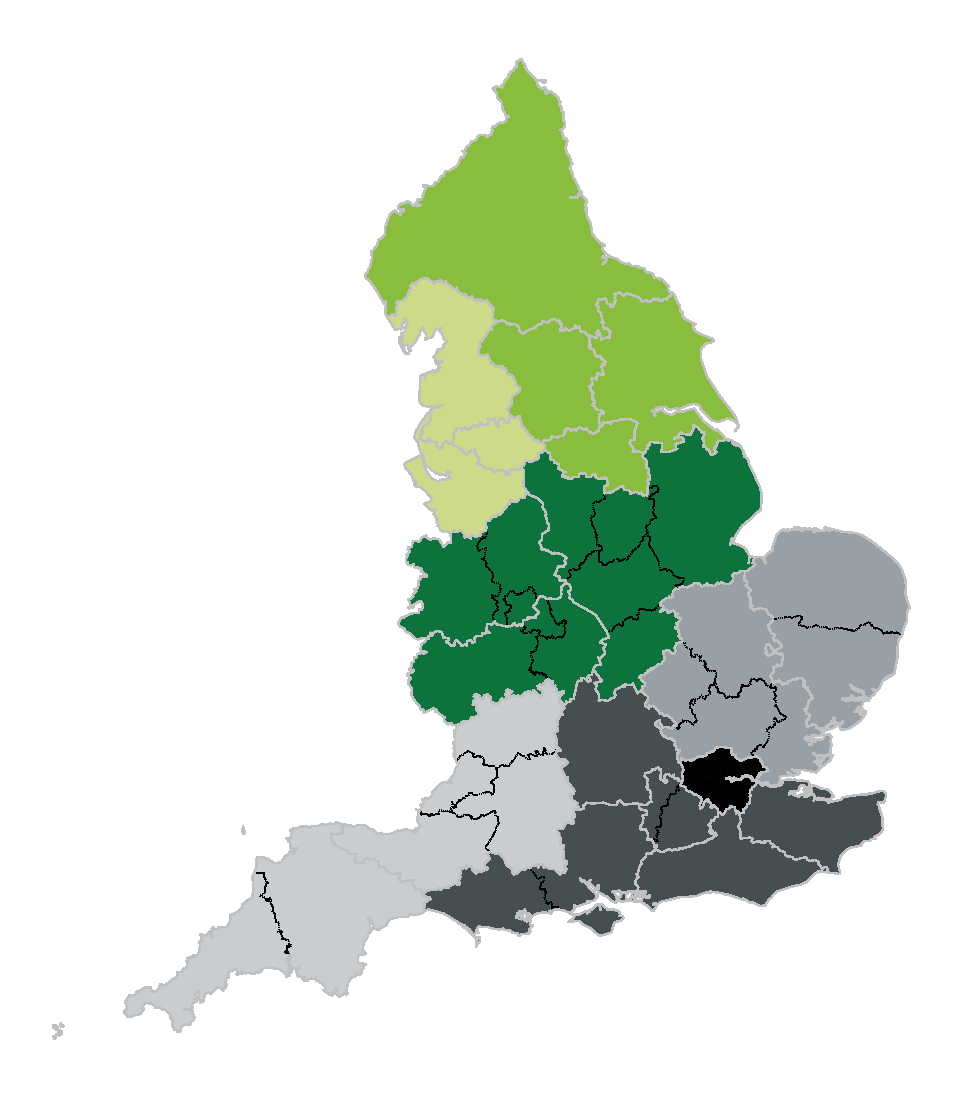

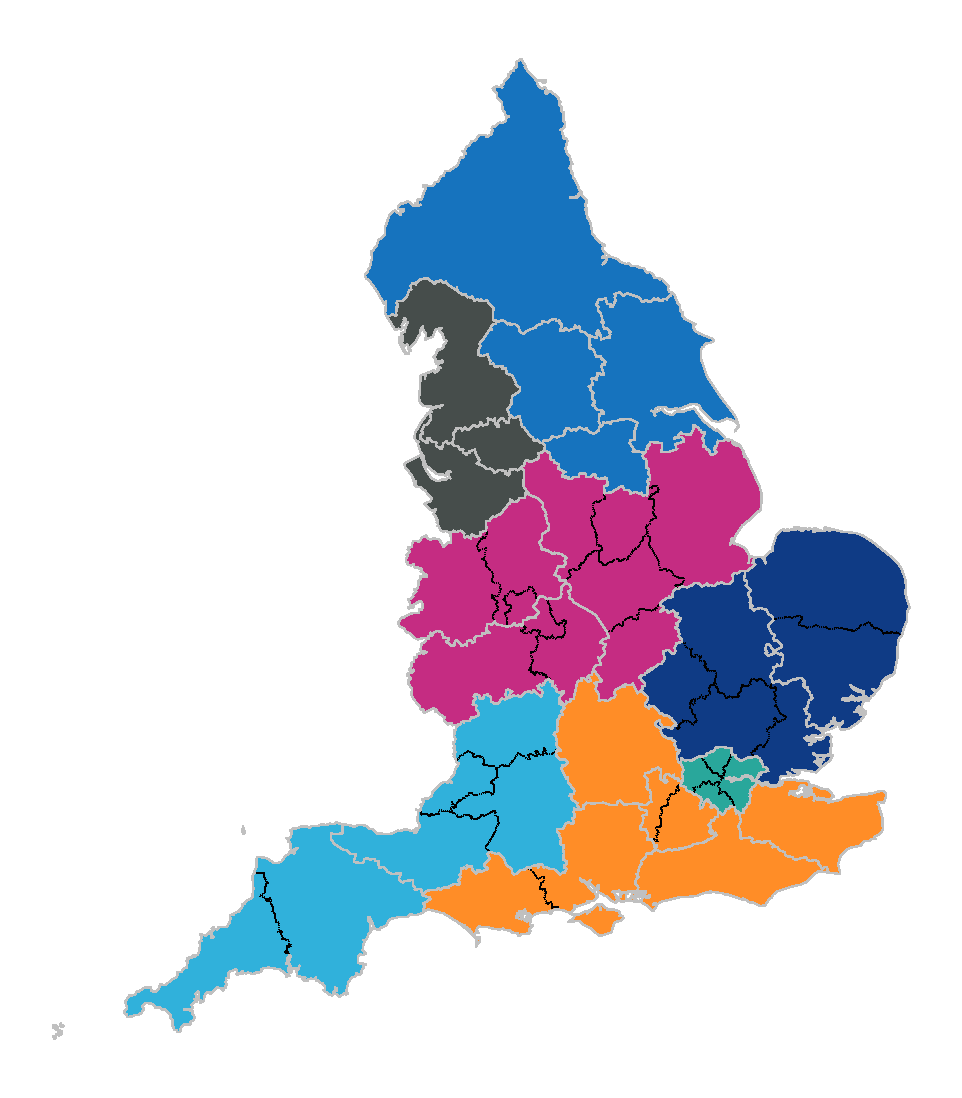

In [48]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## STP 2019

In [13]:
file_input = 'STP_Apr_2019_GCB_in_England_2022_3138810296697318496.geojson'
col_name = 'stp19nm'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['OBJECTID', 'stp19cd', 'stp19nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


In [14]:
print(gdf_boundaries.index)

Index(['West Yorkshire and Harrogate (Health and Care Partnership)',
       'Humber, Coast and Vale',
       'Greater Manchester Health and Social Care Partnership',
       'Cheshire and Merseyside', 'South Yorkshire and Bassetlaw',
       'Staffordshire and Stoke on Trent', 'Shropshire and Telford and Wrekin',
       'Joined Up Care Derbyshire', 'Lincolnshire',
       'Nottingham and Nottinghamshire Health and Care',
       'Leicester, Leicestershire and Rutland',
       'The Black Country and West Birmingham', 'Birmingham and Solihull',
       'Coventry and Warwickshire', 'Herefordshire and Worcestershire',
       'Northamptonshire', 'Cambridgeshire and Peterborough',
       'Norfolk and Waveney Health and Care Partnership',
       'Suffolk and North East Essex', 'Bedfordshire, Luton and Milton Keynes',
       'Hertfordshire and West Essex', 'Mid and South Essex',
       'North West London Health and Care Partnership',
       'North London Partners in Health and Care',
       'East L

In [15]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'West Yorkshire and Harrogate (Health and Care Partnership)': 'West Yorkshire and Harrogate',
    'Humber, Coast and Vale': 'Humber Coast and Vale',
    'Greater Manchester Health and Social Care Partnership': 'Greater Manchester',
    'Cheshire and Merseyside': 'Cheshire and Merseyside',
    'South Yorkshire and Bassetlaw': 'South Yorkshire',
    'Staffordshire and Stoke on Trent': 'North Midlands',
    'Shropshire and Telford and Wrekin': 'North Midlands',
    'Joined Up Care Derbyshire': 'East Midlands',
    'Lincolnshire': 'East Midlands',
    'Nottingham and Nottinghamshire Health and Care': 'East Midlands',
    'Leicester, Leicestershire and Rutland': 'East Midlands',
    'The Black Country and West Birmingham': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Coventry and Warwickshire': 'West Midlands',
    'Herefordshire and Worcestershire': 'West Midlands',
    'Northamptonshire': 'East Midlands',
    'Cambridgeshire and Peterborough': 'East of England (South)',
    'Norfolk and Waveney Health and Care Partnership': 'East of England (North)',
    'Suffolk and North East Essex': 'East of England (North)',
    'Bedfordshire, Luton and Milton Keynes': 'East of England (South)',
    'Hertfordshire and West Essex': 'East of England (South)',
    'Mid and South Essex': 'East of England (South)',
    'North West London Health and Care Partnership': 'London',
    'North London Partners in Health and Care': 'London',
    'East London Health and Care Partnership': 'London',
    'Our Healthier South East London': 'London',
    'South West London Health and Care Partnership': 'London',
    'Kent and Medway': 'Kent and Medway',
    'Sussex and East Surrey': 'Sussex',
    'Frimley Health': 'Frimley ICS',
    'Surrey Heartlands': 'Frimley ICS',
    'Cornwall and the Isles of Scilly': 'Devon, Cornwall and Isles of Scilly',
    'Devon': 'Devon, Cornwall and Isles of Scilly',
    'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
    'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Bath and North East Somerset, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Dorset': 'Wessex',
    'Hampshire and the Isle of Wight': 'Wessex',
    'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
    'Healthier Lancashire and South Cumbria': 'Lancashire and South Cumbria',
    'Cumbria and North East': 'North East and Cumbria',
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

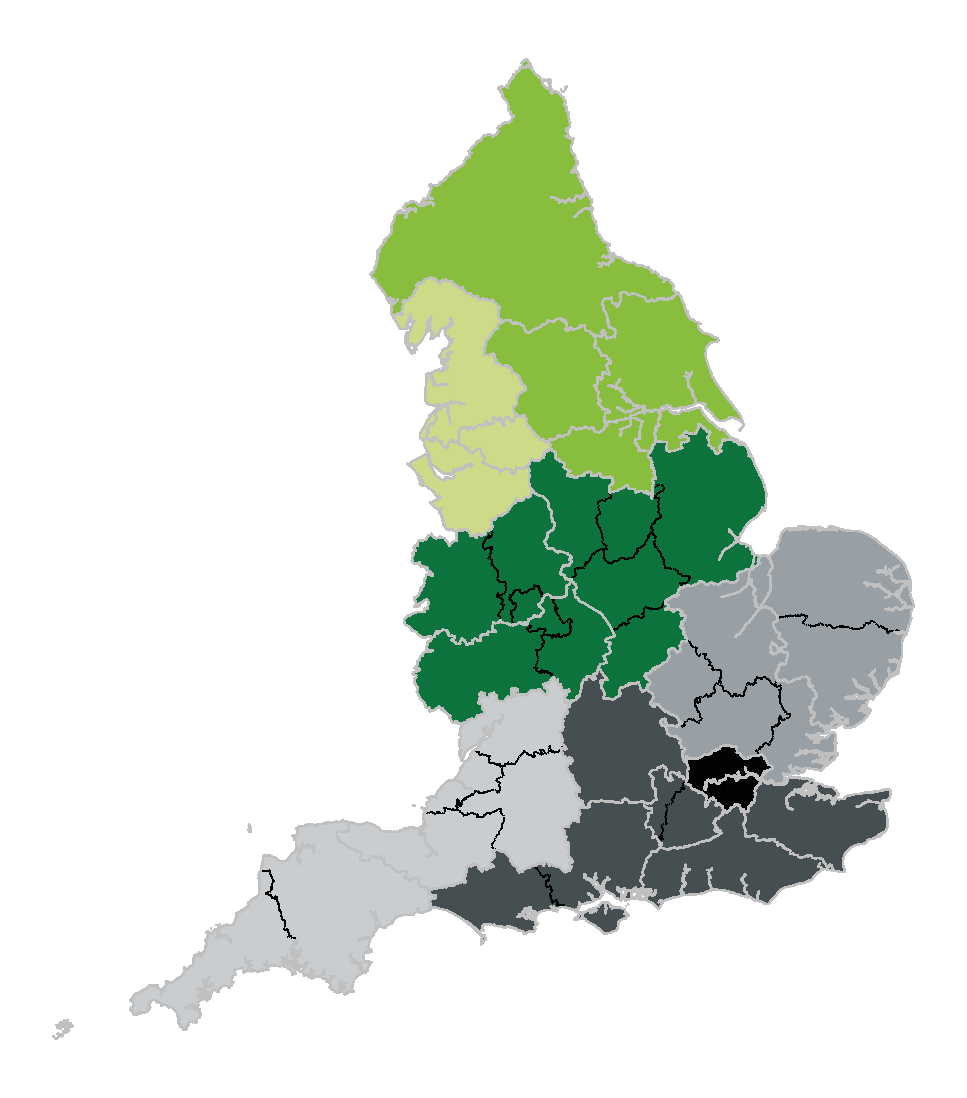

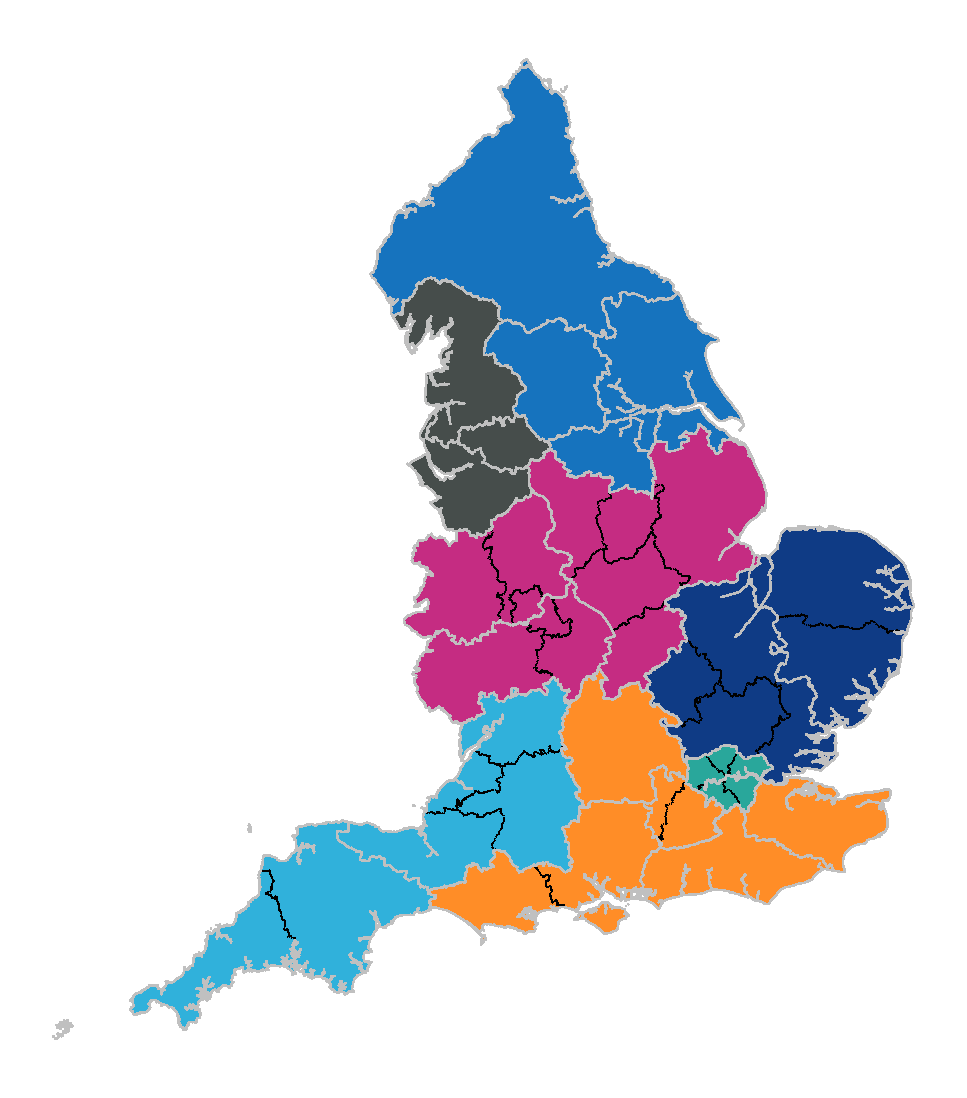

In [16]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## STP 2020

In [17]:
file_input = 'STP_Apr_2020_GCB_in_England_2022_-1081521755956819308.geojson'
col_name = 'stp20nm'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['OBJECTID', 'stp20cd', 'stp20nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


In [18]:
print(gdf_boundaries.index)

Index(['Greater Manchester Health and Social Care Partnership',
       'Cheshire and Merseyside', 'South Yorkshire and Bassetlaw',
       'Staffordshire and Stoke on Trent', 'Shropshire and Telford and Wrekin',
       'Joined Up Care Derbyshire', 'Lincolnshire',
       'Nottingham and Nottinghamshire Health and Care',
       'Leicester, Leicestershire and Rutland',
       'The Black Country and West Birmingham', 'Birmingham and Solihull',
       'Coventry and Warwickshire', 'Herefordshire and Worcestershire',
       'Northamptonshire', 'Cambridgeshire and Peterborough',
       'Norfolk and Waveney Health and Care Partnership',
       'Suffolk and North East Essex', 'Bedfordshire, Luton and Milton Keynes',
       'Hertfordshire and West Essex', 'Mid and South Essex',
       'North West London Health and Care Partnership',
       'North London Partners in Health and Care',
       'East London Health and Care Partnership',
       'Our Healthier South East London',
       'South West Londo

In [19]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'Greater Manchester Health and Social Care Partnership': 'Greater Manchester',
    'Cheshire and Merseyside': 'Cheshire and Merseyside',
    'South Yorkshire and Bassetlaw': 'South Yorkshire',
    'Staffordshire and Stoke on Trent': 'North Midlands',
    'Shropshire and Telford and Wrekin': 'North Midlands',
    'Joined Up Care Derbyshire': 'East Midlands',
    'Lincolnshire': 'East Midlands',
    'Nottingham and Nottinghamshire Health and Care': 'East Midlands',
    'Leicester, Leicestershire and Rutland': 'East Midlands',
    'The Black Country and West Birmingham': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Coventry and Warwickshire': 'West Midlands',
    'Herefordshire and Worcestershire': 'West Midlands',
    'Northamptonshire': 'East Midlands',
    'Cambridgeshire and Peterborough': 'East of England (South)',
    'Norfolk and Waveney Health and Care Partnership': 'East of England (North)',
    'Suffolk and North East Essex': 'East of England (North)',
    'Bedfordshire, Luton and Milton Keynes': 'East of England (South)',
    'Hertfordshire and West Essex': 'East of England (South)',
    'Mid and South Essex': 'East of England (South)',
    'North West London Health and Care Partnership': 'London',
    'North London Partners in Health and Care': 'London',
    'East London Health and Care Partnership': 'London',
    'Our Healthier South East London': 'London',
    'South West London Health and Care Partnership': 'London',
    'Kent and Medway': 'Kent and Medway',
    'Frimley Health and Care ICS': 'Frimley ICS',
    'Cornwall and the Isles of Scilly Health and Social Care Partnership': 'Devon, Cornwall and Isles of Scilly',
    'Devon': 'Devon, Cornwall and Isles of Scilly',
    'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
    'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Bath and North East Somerset, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Dorset': 'Wessex',
    'Hampshire and the Isle of Wight': 'Wessex',
    'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
    'Healthier Lancashire and South Cumbria': 'Lancashire and South Cumbria',
    'Cumbria and North East': 'North East and Cumbria',
    'Humber, Coast and Vale': 'Humber Coast and Vale',
    'Surrey Heartlands Health and Care Partnership': 'Frimley ICS',
    'Sussex and East Surrey Health and Care Partnership': 'Sussex',
    'West Yorkshire and Harrogate (Health and Care Partnership)': 'West Yorkshire and Harrogate',
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

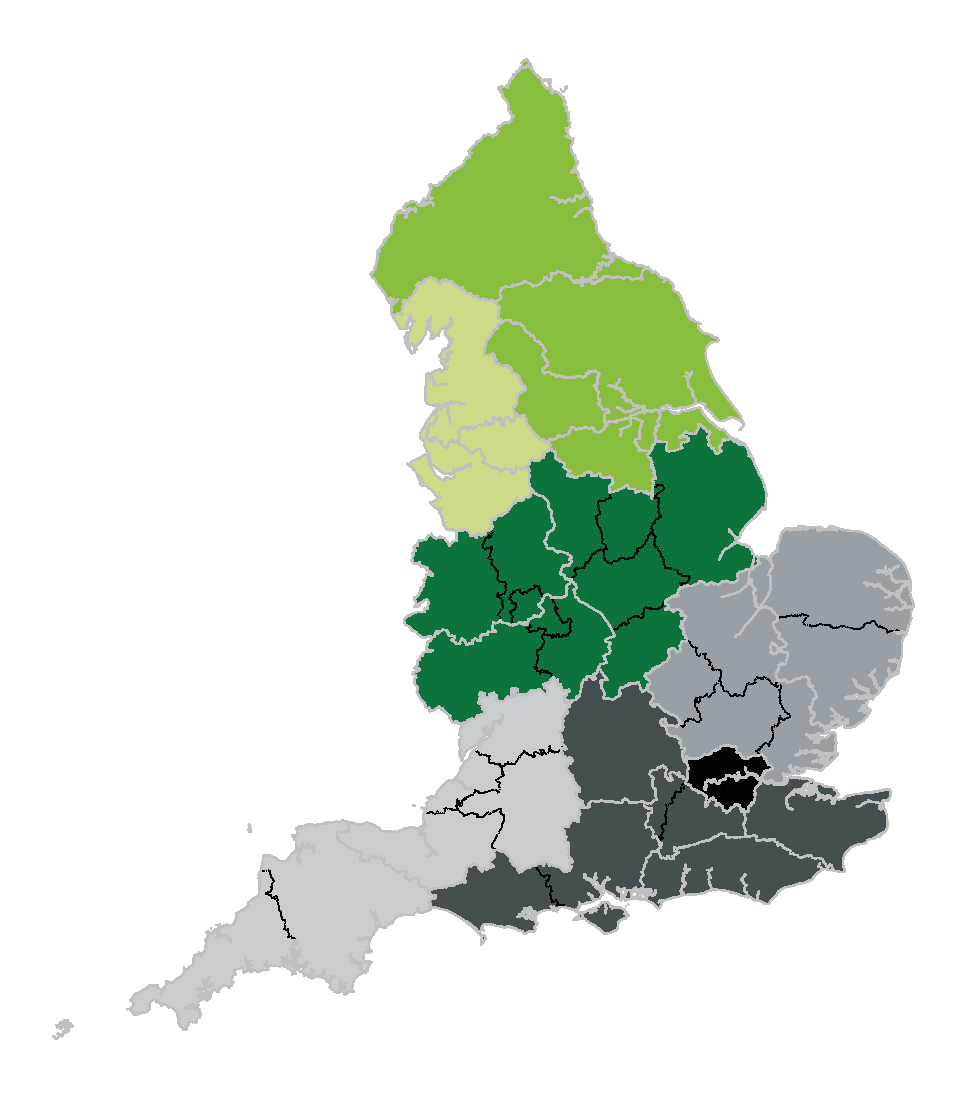

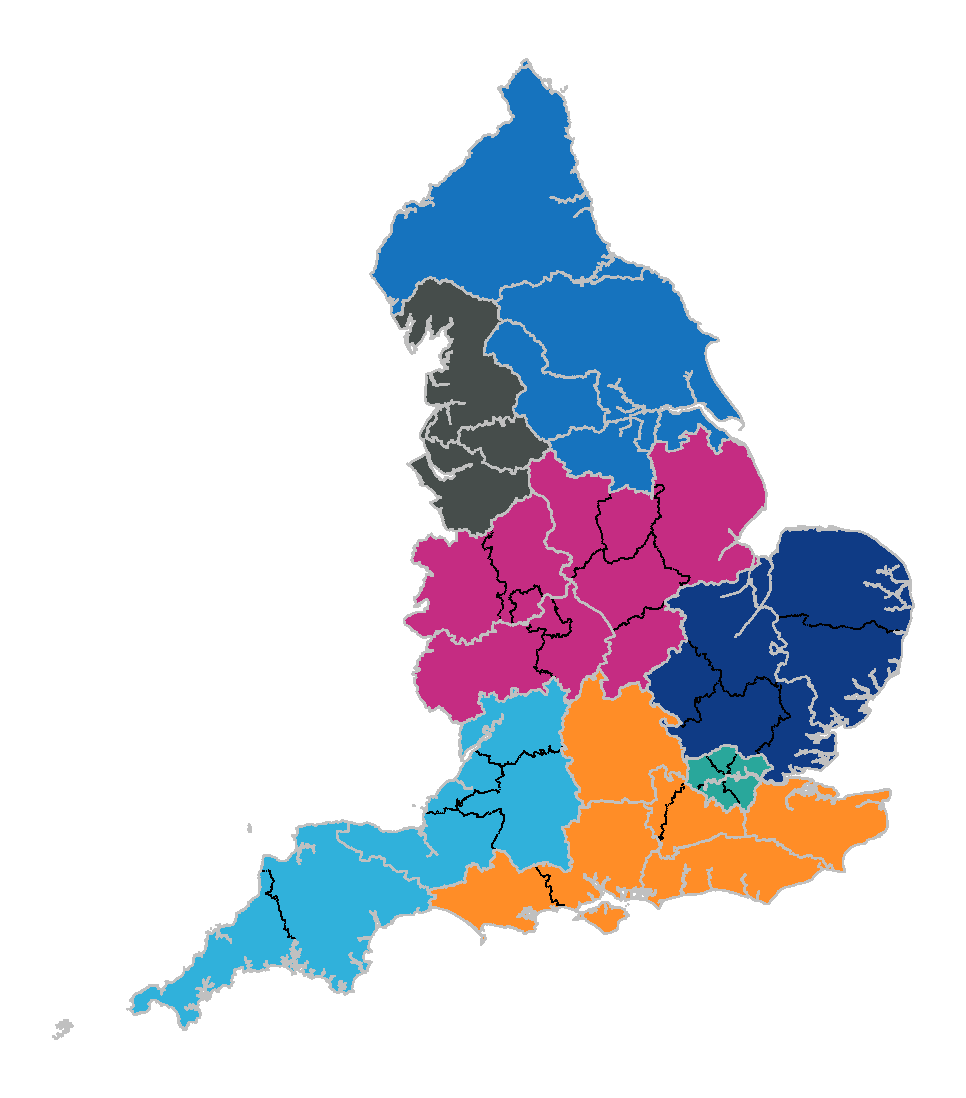

In [20]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## STP 2021

In [21]:
file_input = 'Sustainability_and_Transformation_Partnerships_April_2021_EN_BUC_V2_2022_8439332109500903668.geojson'
col_name = 'STP21NM'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['OBJECTID', 'STP21CD', 'STP21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


In [22]:
print(gdf_boundaries.index)

Index(['Greater Manchester Health and Social Care Partnership',
       'Cheshire and Merseyside', 'South Yorkshire and Bassetlaw',
       'Staffordshire and Stoke on Trent', 'Shropshire and Telford and Wrekin',
       'Joined Up Care Derbyshire', 'Lincolnshire',
       'Nottingham and Nottinghamshire Health and Care',
       'Leicester, Leicestershire and Rutland',
       'The Black Country and West Birmingham', 'Birmingham and Solihull',
       'Coventry and Warwickshire', 'Herefordshire and Worcestershire',
       'Northamptonshire', 'Cambridgeshire and Peterborough',
       'Norfolk and Waveney Health and Care Partnership',
       'Suffolk and North East Essex', 'Bedfordshire, Luton and Milton Keynes',
       'Hertfordshire and West Essex', 'Mid and South Essex',
       'North West London Health and Care Partnership',
       'North London Partners in Health and Care',
       'East London Health and Care Partnership',
       'Our Healthier South East London',
       'South West Londo

In [23]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'Greater Manchester Health and Social Care Partnership': 'Greater Manchester',
    'Cheshire and Merseyside': 'Cheshire and Merseyside',
    'South Yorkshire and Bassetlaw': 'South Yorkshire',
    'Staffordshire and Stoke on Trent': 'North Midlands',
    'Shropshire and Telford and Wrekin': 'North Midlands',
    'Joined Up Care Derbyshire': 'East Midlands',
    'Lincolnshire': 'East Midlands',
    'Nottingham and Nottinghamshire Health and Care': 'East Midlands',
    'Leicester, Leicestershire and Rutland': 'East Midlands',
    'The Black Country and West Birmingham': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Coventry and Warwickshire': 'West Midlands',
    'Herefordshire and Worcestershire': 'West Midlands',
    'Northamptonshire': 'East Midlands',
    'Cambridgeshire and Peterborough': 'East of England (South)',
    'Norfolk and Waveney Health and Care Partnership': 'East of England (North)',
    'Suffolk and North East Essex': 'East of England (North)',
    'Bedfordshire, Luton and Milton Keynes': 'East of England (South)',
    'Hertfordshire and West Essex': 'East of England (South)',
    'Mid and South Essex': 'East of England (South)',
    'North West London Health and Care Partnership': 'London',
    'North London Partners in Health and Care': 'London',
    'East London Health and Care Partnership': 'London',
    'Our Healthier South East London': 'London',
    'South West London Health and Care Partnership': 'London',
    'Kent and Medway': 'Kent and Medway',
    'Frimley Health and Care ICS': 'Frimley ICS',
    'Cornwall and the Isles of Scilly Health and Social Care Partnership': 'Devon, Cornwall and Isles of Scilly',
    'Devon': 'Devon, Cornwall and Isles of Scilly',
    'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
    'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Bath and North East Somerset, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Dorset': 'Wessex',
    'Hampshire and the Isle of Wight': 'Wessex',
    'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
    'Healthier Lancashire and South Cumbria': 'Lancashire and South Cumbria',
    'Cumbria and North East': 'North East and Cumbria',
    'Humber, Coast and Vale': 'Humber Coast and Vale',
    'Surrey Heartlands Health and Care Partnership': 'Frimley ICS',
    'Sussex Health and Care Partnership': 'Sussex',
    'West Yorkshire and Harrogate (Health and Care Partnership)': 'West Yorkshire and Harrogate',
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

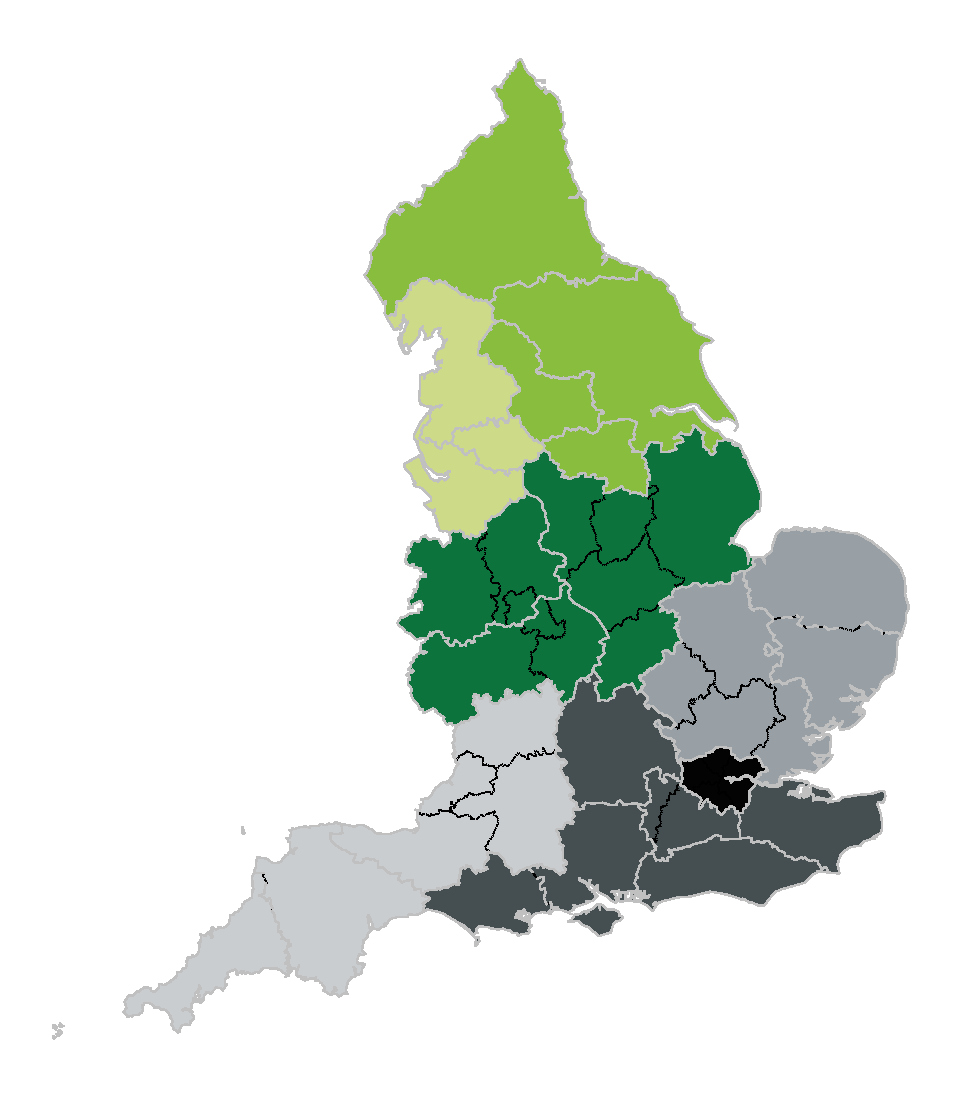

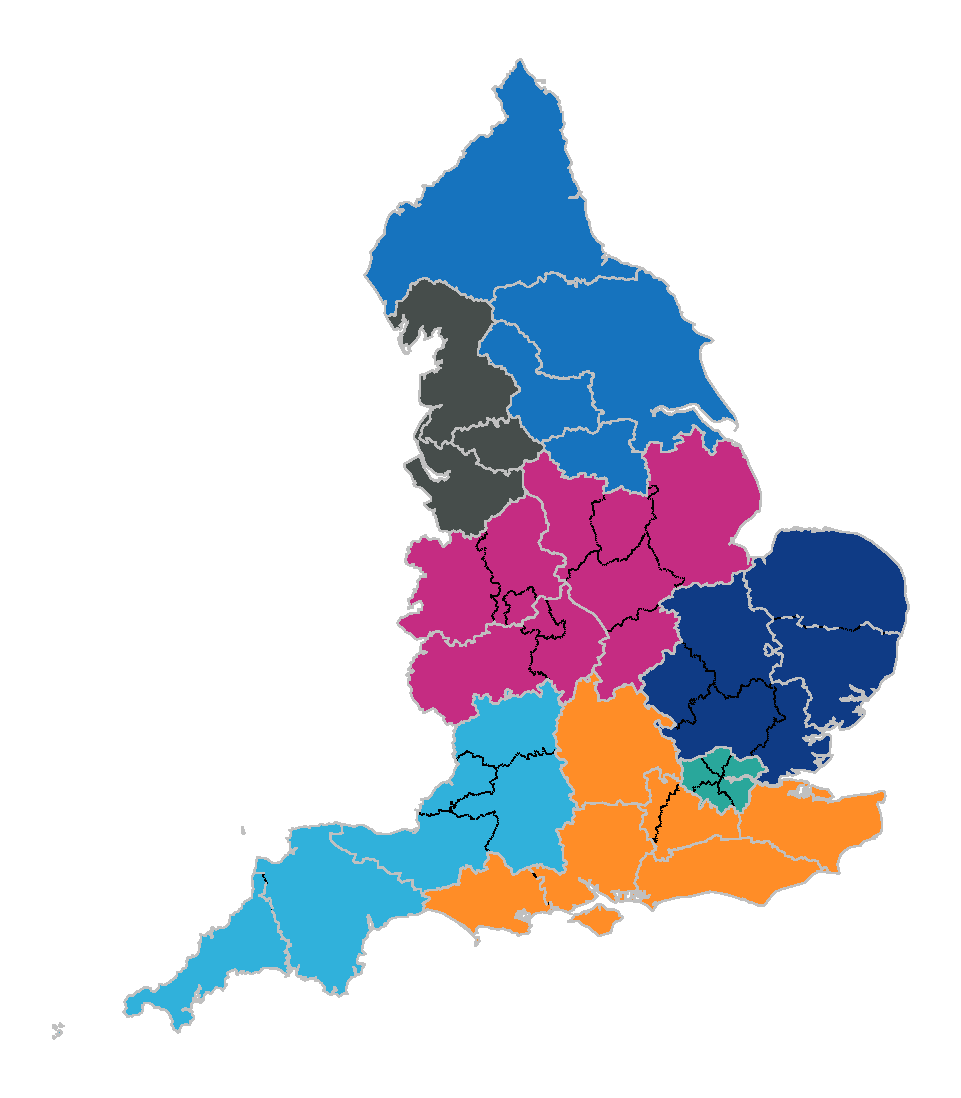

In [24]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## ICB 2022

In [39]:
file_input = 'ICB_JUL_2022_EN_BGC_V3_7901616774526941461.geojson'
col_name = 'ICB22NM'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['ICB22CD', 'ICB22NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'OBJECTID',
       'geometry'],
      dtype='object')


In [40]:
print(gdf_boundaries.index)

Index(['NHS Cheshire and Merseyside Integrated Care Board',
       'NHS Staffordshire and Stoke-on-Trent Integrated Care Board',
       'NHS Shropshire, Telford and Wrekin Integrated Care Board',
       'NHS Lincolnshire Integrated Care Board',
       'NHS Leicester, Leicestershire and Rutland Integrated Care Board',
       'NHS Coventry and Warwickshire Integrated Care Board',
       'NHS Herefordshire and Worcestershire Integrated Care Board',
       'NHS Norfolk and Waveney Integrated Care Board',
       'NHS Suffolk and North East Essex Integrated Care Board',
       'NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board',
       'NHS Hertfordshire and West Essex Integrated Care Board',
       'NHS Mid and South Essex Integrated Care Board',
       'NHS North West London Integrated Care Board',
       'NHS North Central London Integrated Care Board',
       'NHS North East London Integrated Care Board',
       'NHS South East London Integrated Care Board',
       'NHS Sou

In [41]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'NHS Cheshire and Merseyside Integrated Care Board': 'Cheshire and Merseyside',
    'NHS Staffordshire and Stoke-on-Trent Integrated Care Board': 'North Midlands',
    'NHS Shropshire, Telford and Wrekin Integrated Care Board': 'North Midlands',
    'NHS Lincolnshire Integrated Care Board': 'East Midlands',
    'NHS Leicester, Leicestershire and Rutland Integrated Care Board': 'East Midlands',
    'NHS Coventry and Warwickshire Integrated Care Board': 'West Midlands',
    'NHS Herefordshire and Worcestershire Integrated Care Board': 'West Midlands',
    'NHS Norfolk and Waveney Integrated Care Board': 'East of England (North)',
    'NHS Suffolk and North East Essex Integrated Care Board': 'East of England (North)',
    'NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board': 'East of England (South)',
    'NHS Hertfordshire and West Essex Integrated Care Board': 'East of England (South)',
    'NHS Mid and South Essex Integrated Care Board': 'East of England (South)',
    'NHS North West London Integrated Care Board': 'London',
    'NHS North Central London Integrated Care Board': 'London',
    'NHS North East London Integrated Care Board': 'London',
    'NHS South East London Integrated Care Board': 'London',
    'NHS South West London Integrated Care Board': 'London',
    'NHS Kent and Medway Integrated Care Board': 'Kent and Medway',
    'NHS Frimley Integrated Care Board': 'Frimley ICS',
    'NHS Cornwall and the Isles of Scilly Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Devon Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Somerset Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Dorset Integrated Care Board': 'Wessex',
    'NHS Hampshire and Isle of Wight Integrated Care Board': 'Wessex',
    'NHS Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board': 'Thames Valley',
    'NHS Lancashire and South Cumbria Integrated Care Board': 'Lancashire and South Cumbria',
    'NHS North East and North Cumbria Integrated Care Board': 'North East and Cumbria',
    'NHS Humber and North Yorkshire Integrated Care Board': 'Humber Coast and Vale',
    'NHS Surrey Heartlands Integrated Care Board': 'Frimley ICS',
    'NHS Sussex Integrated Care Board': 'Sussex',
    'NHS West Yorkshire Integrated Care Board': 'West Yorkshire and Harrogate',
    'NHS Birmingham and Solihull Integrated Care Board': 'West Midlands',
    'NHS Cambridgeshire and Peterborough Integrated Care Board': 'East of England (South)',
    'NHS Greater Manchester Integrated Care Board': 'Greater Manchester',
    'NHS Derby and Derbyshire Integrated Care Board': 'East Midlands',
    'NHS Northamptonshire Integrated Care Board': 'East Midlands',
    'NHS Nottingham and Nottinghamshire Integrated Care Board': 'East Midlands',
    'NHS South Yorkshire Integrated Care Board': 'South Yorkshire',
    'NHS Black Country Integrated Care Board': 'North Midlands'
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

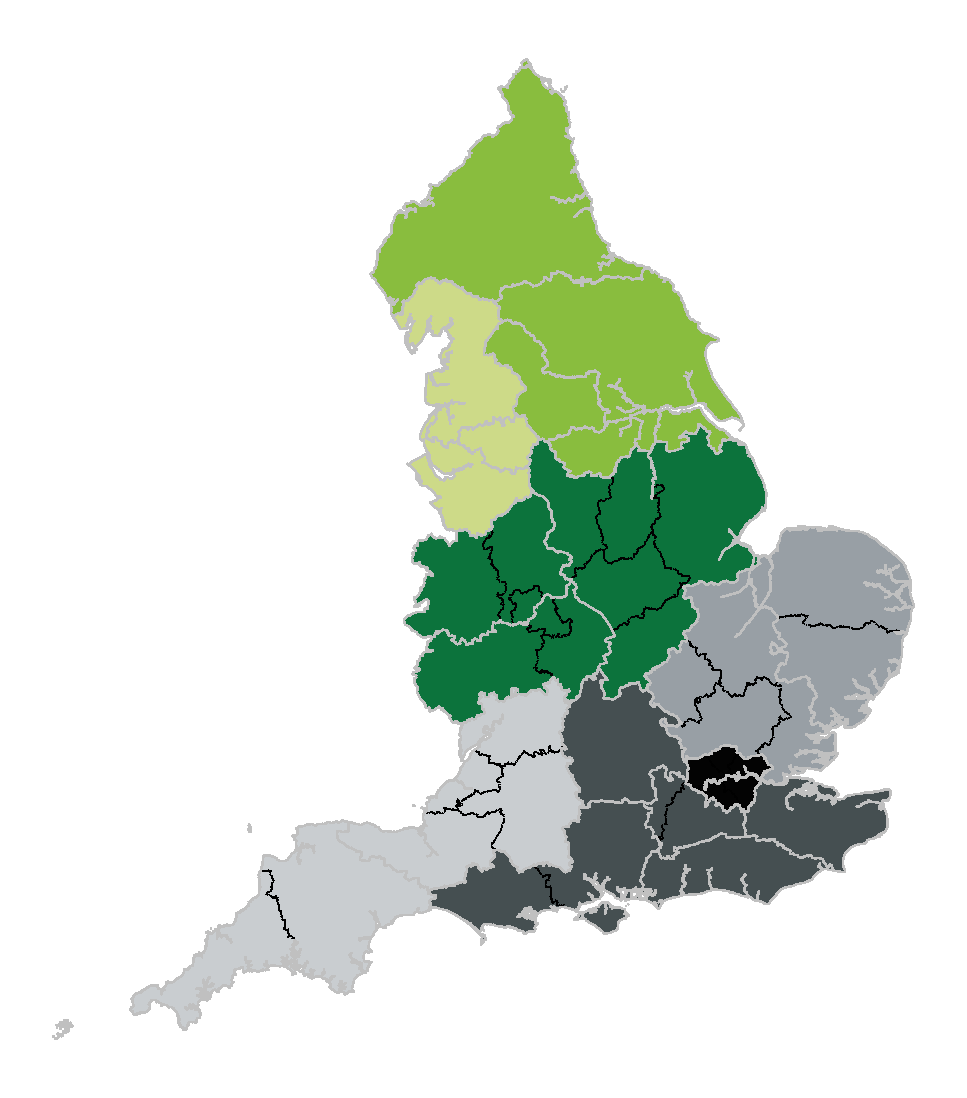

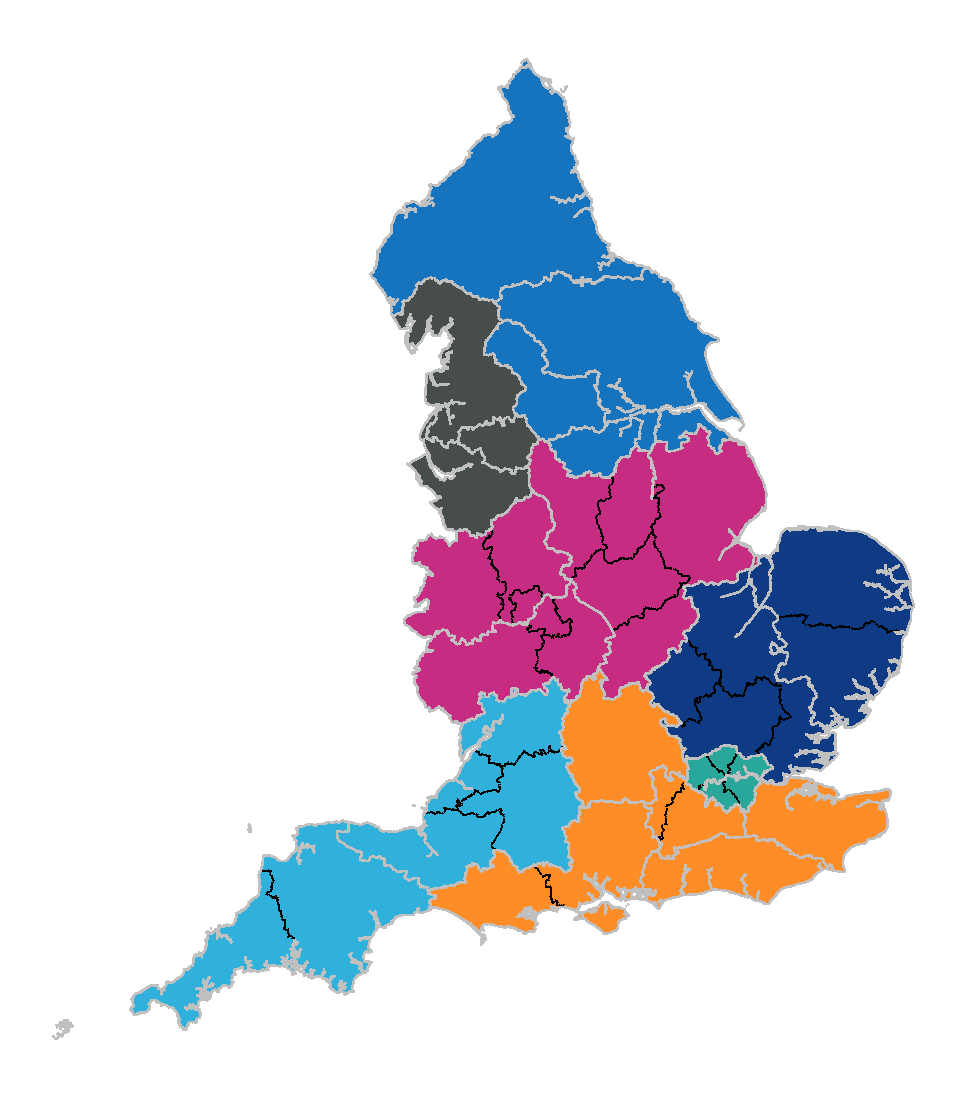

In [42]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

## ICB 2023

In [49]:
file_input = 'Integrated_Care_Boards_April_2023_EN_BGC_-5820614070354969176(1).geojson'
col_name = 'ICB23NM'

# Import region file:
dir_input = '../data_geojson/ons_data/'
path_to_file = os.path.join(dir_input, file_input)
gdf_boundaries = geopandas.read_file(path_to_file)

print(gdf_boundaries.columns)

gdf_boundaries = gdf_boundaries.set_index(col_name)

Index(['FID', 'ICB23CD', 'ICB23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


In [50]:
print(gdf_boundaries.index)

Index(['NHS Cheshire and Merseyside Integrated Care Board',
       'NHS Staffordshire and Stoke-on-Trent Integrated Care Board',
       'NHS Shropshire, Telford and Wrekin Integrated Care Board',
       'NHS Lincolnshire Integrated Care Board',
       'NHS Leicester, Leicestershire and Rutland Integrated Care Board',
       'NHS Coventry and Warwickshire Integrated Care Board',
       'NHS Herefordshire and Worcestershire Integrated Care Board',
       'NHS Norfolk and Waveney Integrated Care Board',
       'NHS Suffolk and North East Essex Integrated Care Board',
       'NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board',
       'NHS Hertfordshire and West Essex Integrated Care Board',
       'NHS Mid and South Essex Integrated Care Board',
       'NHS North West London Integrated Care Board',
       'NHS North Central London Integrated Care Board',
       'NHS North East London Integrated Care Board',
       'NHS South East London Integrated Care Board',
       'NHS Sou

In [51]:
# Manually assign an ISDN to these regions:
isdn_dict = {
    'NHS Cheshire and Merseyside Integrated Care Board': 'Cheshire and Merseyside',
    'NHS Staffordshire and Stoke-on-Trent Integrated Care Board': 'North Midlands',
    'NHS Shropshire, Telford and Wrekin Integrated Care Board': 'North Midlands',
    'NHS Lincolnshire Integrated Care Board': 'East Midlands',
    'NHS Leicester, Leicestershire and Rutland Integrated Care Board': 'East Midlands',
    'NHS Coventry and Warwickshire Integrated Care Board': 'West Midlands',
    'NHS Herefordshire and Worcestershire Integrated Care Board': 'West Midlands',
    'NHS Norfolk and Waveney Integrated Care Board': 'East of England (North)',
    'NHS Suffolk and North East Essex Integrated Care Board': 'East of England (North)',
    'NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board': 'East of England (South)',
    'NHS Hertfordshire and West Essex Integrated Care Board': 'East of England (South)',
    'NHS Mid and South Essex Integrated Care Board': 'East of England (South)',
    'NHS North West London Integrated Care Board': 'London',
    'NHS North Central London Integrated Care Board': 'London',
    'NHS North East London Integrated Care Board': 'London',
    'NHS South East London Integrated Care Board': 'London',
    'NHS South West London Integrated Care Board': 'London',
    'NHS Kent and Medway Integrated Care Board': 'Kent and Medway',
    'NHS Frimley Integrated Care Board': 'Frimley ICS',
    'NHS Cornwall and the Isles of Scilly Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Devon Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Somerset Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Dorset Integrated Care Board': 'Wessex',
    'NHS Hampshire and Isle of Wight Integrated Care Board': 'Wessex',
    'NHS Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board': 'Thames Valley',
    'NHS Lancashire and South Cumbria Integrated Care Board': 'Lancashire and South Cumbria',
    'NHS North East and North Cumbria Integrated Care Board': 'North East and Cumbria',
    'NHS Humber and North Yorkshire Integrated Care Board': 'Humber Coast and Vale',
    'NHS Surrey Heartlands Integrated Care Board': 'Frimley ICS',
    'NHS Sussex Integrated Care Board': 'Sussex',
    'NHS West Yorkshire Integrated Care Board': 'West Yorkshire and Harrogate',
    'NHS Birmingham and Solihull Integrated Care Board': 'West Midlands',
    'NHS Cambridgeshire and Peterborough Integrated Care Board': 'East of England (South)',
    'NHS Greater Manchester Integrated Care Board': 'Greater Manchester',
    'NHS Derby and Derbyshire Integrated Care Board': 'East Midlands',
    'NHS Northamptonshire Integrated Care Board': 'East Midlands',
    'NHS Nottingham and Nottinghamshire Integrated Care Board': 'East Midlands',
    'NHS South Yorkshire Integrated Care Board': 'South Yorkshire',
    'NHS Black Country Integrated Care Board': 'North Midlands'
}

# Convert region-to-ISDN dictionary to a Series:
isdn_series = pd.Series(isdn_dict, name='ISDN')
isdn_series.index.name=col_name

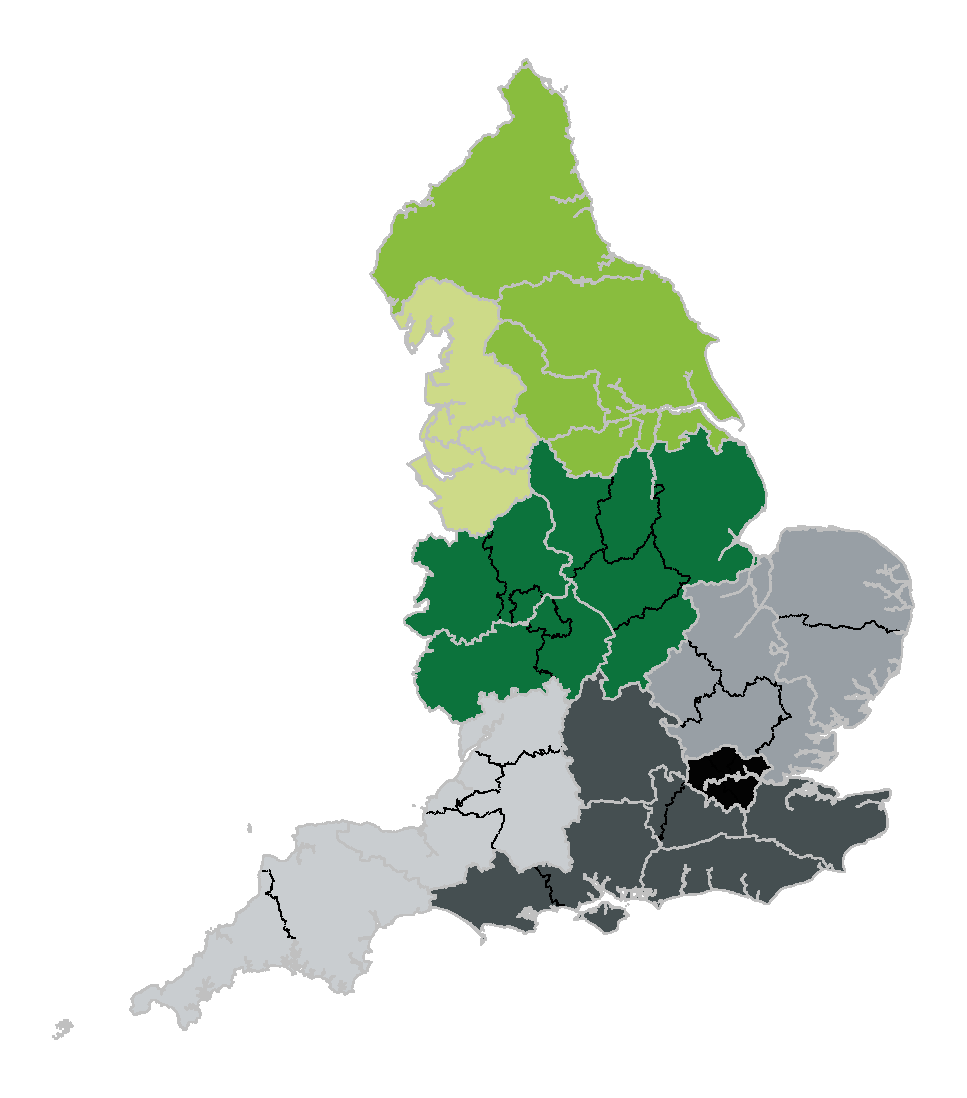

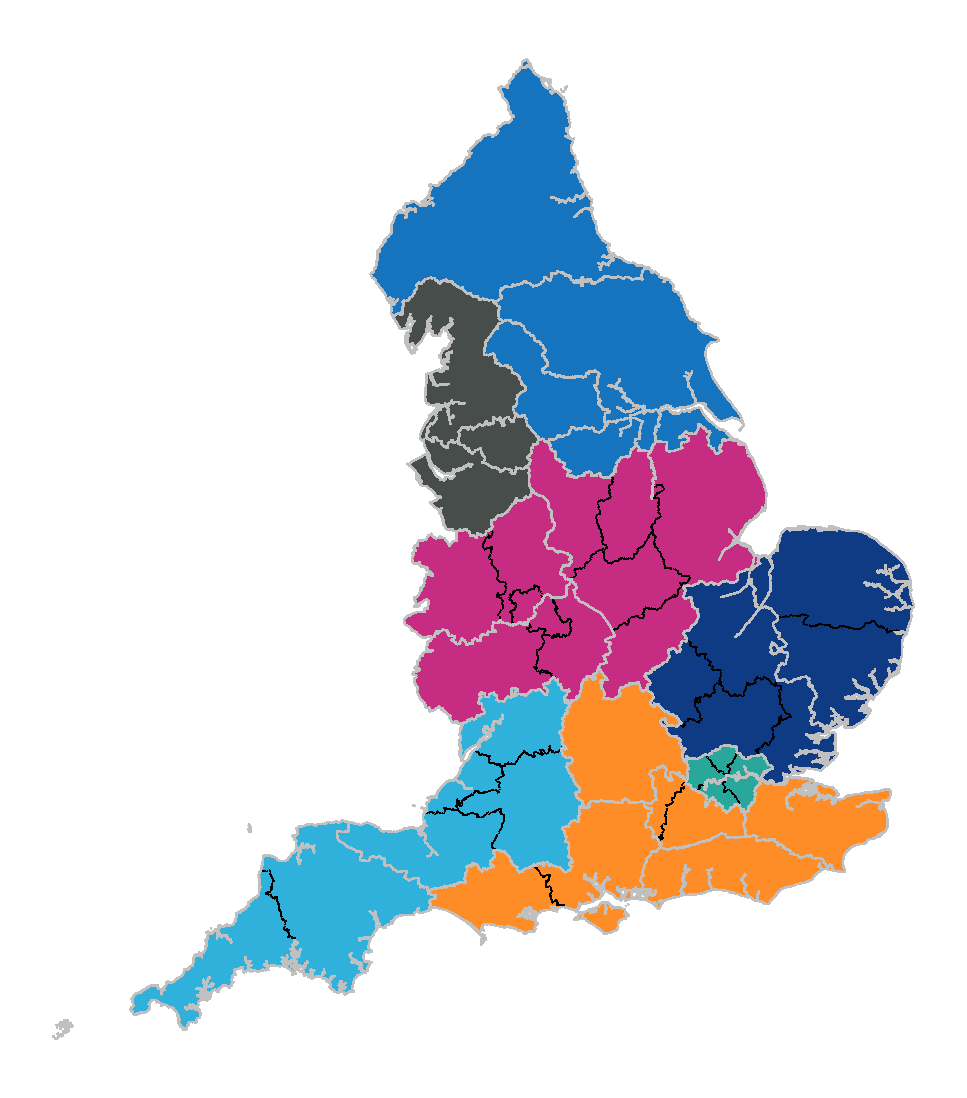

In [52]:
for colour, colour_series in colour_series_dict.items():
    gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(gdf_boundaries, isdn_series, colour_series)
    plot_map(gdf_boundaries_colours, gdf_boundaries_isdn, savename=f'{col_name}_{colour}.jpg')

In [53]:
gdf_boundaries_colours

,FID,ICB23CD,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,ISDN,colour
ICB23NM,,,,,,,,,,
NHS Cheshire and Merseyside Integrated Care Board,1,E54000008,374405,380936,-2.385720,53.32473,ad50edea-59a7-4bab-94f5-8b6f4ca04f96,"MULTIPOLYGON (((327828.613 373756.171, 327850....",Cheshire and Merseyside,#464d4b
NHS Staffordshire and Stoke-on-Trent Integrated Care Board,2,E54000010,398243,334651,-2.027560,52.90930,ade6aec0-059b-40dd-a702-d36c38d912cf,"POLYGON ((403403.619 368312.537, 403605.406 36...",North Midlands,#c52c82
"NHS Shropshire, Telford and Wrekin Integrated Care Board",3,E54000011,350226,302960,-2.736680,52.62212,df85459a-9230-4100-b7ef-ccc6cfbebb27,"POLYGON ((374540.377 344631.404, 374599.625 34...",North Midlands,#c52c82
NHS Lincolnshire Integrated Care Board,4,E54000013,517984,358538,-0.238840,53.11101,adaaf962-1ce3-4d53-8f7d-ad3b9691f245,"MULTIPOLYGON (((552996.144 326664.682, 552917....",East Midlands,#c52c82
"NHS Leicester, Leicestershire and Rutland Integrated Care Board",5,E54000015,466552,310188,-1.016900,52.68532,5dc7b0e4-c160-4ffc-a212-b18046f17892,"POLYGON ((481509.452 342937.104, 481725.188 34...",East Midlands,#c52c82
NHS Coventry and Warwickshire Integrated Care Board,6,E54000018,429584,266724,-1.567600,52.29786,9accccb4-728b-4f69-af36-6fda3fe06b54,"POLYGON ((428654.406 309068.156, 428704.906 30...",West Midlands,#c52c82
NHS Herefordshire and Worcestershire Integrated Care Board,7,E54000019,364519,249269,-2.519860,52.14057,7eadb3fa-ff5e-49f3-b2d3-9036e7db594a,"POLYGON ((381603.905 282450.186, 381795.964 28...",West Midlands,#c52c82
NHS Norfolk and Waveney Integrated Care Board,8,E54000022,600616,310723,0.964749,52.65712,2699aa3b-7528-45ed-a481-b9a77f8e443d,"MULTIPOLYGON (((650020.163 274722.939, 649952....",East of England (North),#0f3b85
NHS Suffolk and North East Essex Integrated Care Board,9,E54000023,596764,250276,0.872415,52.11579,9543affd-1448-4023-b9ee-1e701f9e6a1f,"MULTIPOLYGON (((600151.270 212257.500, 600080....",East of England (North),#0f3b85
